In [1]:
%config Completer.use_jedi = False
%load_ext autoreload

from collections import defaultdict
import re, time, os, shutil, json
from easydict import EasyDict as edict
import matplotlib.pyplot as plt
import numpy as np
import nibabel as nib
from PIL import Image
import tempfile
from utils import get_label, to_numpy
from dataset import assign_feature_maps
import configdot
import torch
from monai.config import print_config
from IPython.core.debugger import set_trace
from tqdm import tqdm


%autoreload 2

In [8]:
subjects_list = np.load('./metadata/metadata_fcd_nG.npy', allow_pickle=True).item()
subjects_all = np.concatenate([subjects_list['train'], subjects_list['test']])
features_all = ['image', 
                 't2', 
                 'flair', 
                 'blurring-t1', 
                 'blurring-t2', 
                 'blurring-Flair', 
                 'cr-t2', 
                 'cr-Flair', 
                 'thickness', 
                 'curv', 
                 'sulc', 
                 'variance', 
                 'entropy']

# Plot histograms for each feature across different subjects  

In [17]:
minmax_all = {}
mean_std_all = {}
features_hist_all = {}

for feature in tqdm(features_all):
    
    max_values = []
    min_values = []
    
    # cumulative statistics
    S = 0
    S_square = 0
    N = 0
    # list of hists for each subj
    features_hist_list = []
    for sub in subjects_all:
        # return whole path
        fpath = assign_feature_maps(sub, feature)
        mpath = assign_feature_maps(sub, 'mask')
        fdata = nib.load(fpath).get_fdata()
        fmask = nib.load(mpath).get_fdata()
        mask = fmask > 0 # binary mask indicating brain vs background
        
        hist, bins = np.histogram(fdata[mask], bins=50)
        
        S += fdata[mask].sum()
        S_square += np.power(fdata[mask], 2).sum()
        N += fdata[mask].shape[0]
        
        min_values.append(fdata[mask].min())
        max_values.append(fdata[mask].max())
        
        features_hist_list.append([hist, bins])
        
    mean = S/N
    std = np.sqrt((S_square/N) - (mean**2))
    mean_std_all[feature] = [mean, std]
    features_hist_all[feature] = features_hist_list
    minmax_all[feature] = [np.min(min_values), np.max(max_values)]     

100%|██████████| 13/13 [11:29<00:00, 53.06s/it]


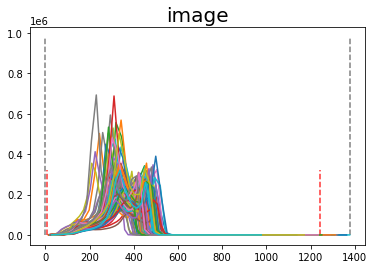

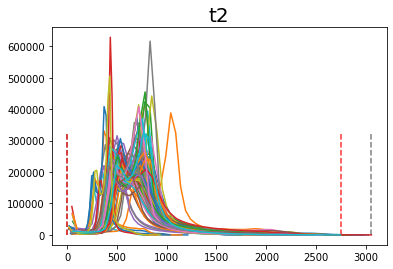

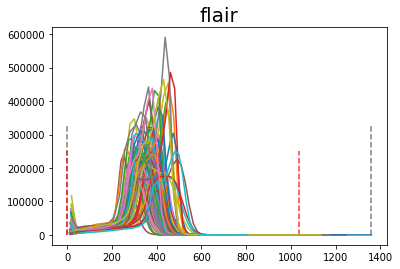

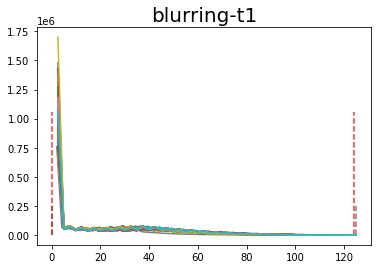

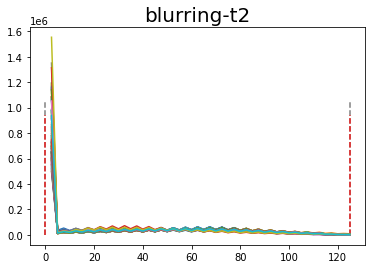

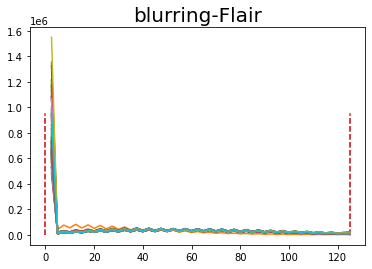

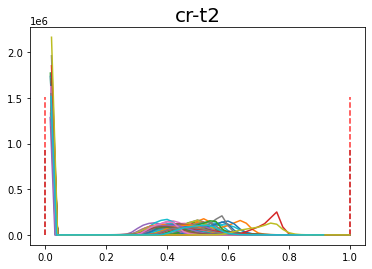

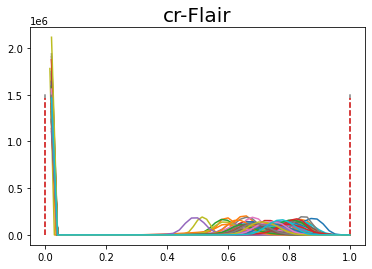

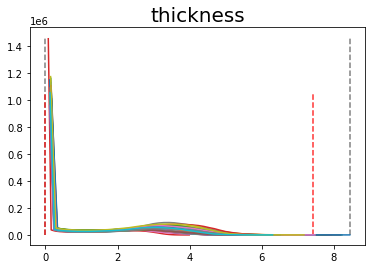

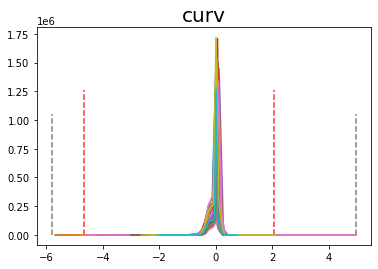

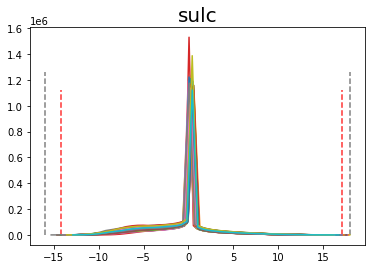

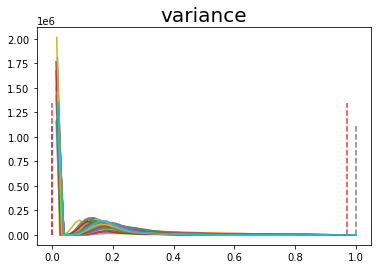

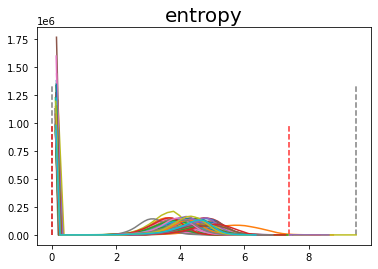

In [26]:
bins_all = defaultdict(list)
quantiles_all = {}
for feature in features_all:
    
    plt.figure()
    
    # min-max 
    plt.vlines(minmax_all[feature][0], 0, hist.max(), linestyle='--', alpha=0.5, color='black')
    plt.vlines(minmax_all[feature][1], 0, hist.max(), linestyle='--', alpha=0.5, color='black')
    
    for k, (hist, bins) in enumerate(features_hist_all[feature]):
        plt.plot(bins[1:], hist)
        bins_all[feature].append(bins)
    bins_all[feature] = np.concatenate(bins_all[feature])
    
    # quantiles
    q_min = np.quantile(bins_all[feature], q=0.01)
    q_max = np.quantile(bins_all[feature], q=0.99)
    plt.vlines(q_min, 0, hist.max(), linestyle='--', alpha=0.8, color='red')
    plt.vlines(q_max, 0, hist.max(), linestyle='--', alpha=0.8, color='red')
    quantiles_all[feature] = [q_min, q_max]
    
    # plt.yscale('log')
    plt.title(feature, fontsize=20)
    plt.show()


In [34]:
ab_all = {}

for k,v in minmax_all.items():
    a_min, a_max = v
    a = a_min
    b = a_max - a_min
    ab_all[k] = [a, b]

In [35]:
ab_all

{'image': [0.0, 1376.502685546875],
 't2': [0.0, 3054.7685546875],
 'flair': [0.0, 1359.7103271484375],
 'blurring-t1': [0.0, 125.0],
 'blurring-t2': [0.0, 125.0],
 'blurring-Flair': [0.0, 125.0],
 'cr-t2': [0.0, 1.0],
 'cr-Flair': [0.0, 1.0],
 'thickness': [0.0, 8.444336891174316],
 'curv': [-5.801093578028679, 10.765574664044376],
 'sulc': [-15.947615623474121, 33.96219730377197],
 'variance': [0.0, 1.0],
 'entropy': [0.0, 9.477174909516693]}

In [36]:
mean_std_all

{'image': [328.8842587510113, 88.10715870643544],
 't2': [677.4198283238769, 317.96584710159635],
 'flair': [321.79047992865446, 93.70203854002003],
 'blurring-t1': [19.43408002459893, 22.955221012192922],
 'blurring-t2': [34.898955820090855, 34.60505512233325],
 'blurring-Flair': [36.10324832455116, 36.67819410553321],
 'cr-t2': [0.14891803555096764, 0.21850134592667622],
 'cr-Flair': [0.23272391181969182, 0.3389385258506331],
 'thickness': [1.2301158556442637, 1.4823192834278376],
 'curv': [-0.0616147018719411, 0.13666224376185832],
 'sulc': [-0.8601366578439527, 3.256973259949292],
 'variance': [0.0965674654733997, 0.14997942911941525],
 'entropy': [2.016953600606352, 2.086723372881726]}

In [37]:
np.save('metadata/minmax_scaling_metadata.npy', ab_all)
np.save('metadata/meanstd_scaling_metadata.npy', mean_std_all)

# quntiles_data_path = 'metadata/quantiles_metadata.npy'
# np.save(quntiles_data_path, quantiles_all)

In [38]:
ab_all_ = minmax_all.copy()
mean_std_all_ = mean_std_all.copy()

In [39]:
ab_all_['image'] = None
ab_all_['flair'] = None
ab_all_['t2'] = None

mean_std_all_['image'] = None
mean_std_all_['flair'] = None
mean_std_all_['t2'] = None

In [40]:
np.save('metadata/minmax_scaling_metadata_no-t1-t2-flair.npy', ab_all_)

In [41]:
np.save('metadata/meanstd_scaling_metadata_no-t1-t2-flair.npy', mean_std_all_)

# Amend outliers

In [ ]:
# feature = 'curv'
# # list of hists for each subj
# for sub in tqdm(subjects_all):
#     # return whole path
#     fpath = assign_feature_maps(sub, feature)
#     fnib = nib.load(fpath)
#     fdata = fnib.get_fdata()
#     fdata_ = np.clip(fdata, a_min=q_min, a_max=q_max)
    
#     # fpath_tmp = os.path.join('./tmp', ''.join(fpath.split('/')[-2:]))
    
#     final_img = nib.Nifti1Image(fdata_, fnib.affine)
#     nib.save(final_img, fpath)

In [ ]:
# sub_anom = 'n50'
# fdata_anom = nib.load(assign_feature_maps(sub_anom, 'curv')).get_fdata()
# fmask_anom = nib.load(assign_feature_maps(sub_anom, 'mask')).get_fdata()
# hist, bins = np.histogram(fdata_anom[fmask_anom > 0], bins=50)

In [ ]:
# fdata_anom_ = np.clip(fdata_anom, a_min=q_min, a_max=q_max)
# hist_, bins_ = np.histogram(fdata_anom_[fmask_anom > 0], bins=50)
# plt.plot(bins[1:], hist)
# plt.plot(bins_[1:], hist_, color='red')
# plt.yscale('log')
# plt.show()

In [ ]:
# total_pixnum = np.prod(fdata_anom.shape)
# nonzero_pixnum = fdata_anom[np.abs(fdata_anom) > 1e-3].shape[0]
# anom_pixnum = fdata_anom[fdata_anom > 1].shape[0]
# anom_pixnum / nonzero_pixnum

In [8]:
t1 = torch.get_rng_state()
torch.randn(3)
t2 = torch.get_rng_state()
torch.equal(t1,t2)

False

In [50]:
torch.manual_seed(42)
torch.get_rng_state()[:100]

tensor([ 42,   0,   0,   0,   0,   0,   0,   0,   1,   0,   0,   0,   1,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  42,   0,   0,   0,
          0,   0,   0,   0, 147, 138,  60, 185,   0,   0,   0,   0,  55,  68,
          1, 113,   0,   0,   0,   0,  81, 207, 122, 232,   0,   0,   0,   0,
         94, 173, 164, 180,   0,   0,   0,   0,  81, 161,  66, 243,   0,   0,
          0,   0,  96, 135, 220, 162,   0,   0,   0,   0, 177, 219,  34,  81,
          0,   0,   0,   0, 120, 220,  33, 236,   0,   0,   0,   0, 144, 207,
        182,  51], dtype=torch.uint8)